In [140]:
from datetime import datetime

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error as mape
from numpy import exp

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

In [141]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_month", "post_day", "post_year", "days_since_previous_release", "release_post"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "month", "day"]])
del df["month"]
del df["day"]
del df["year"]
del df["post_month"]
df

,days_since_previous_release,release_post,date
id,,,
50,NaN,False,2016-02-15
123,NaN,False,2016-02-15
173,NaN,False,2016-02-15
156,NaN,False,2016-02-15
133,NaN,False,2016-02-15
...,...,...,...
302,2.0,True,2021-10-16
305,12.0,True,2021-10-28
312,2.0,True,2021-10-30


In [142]:
df.query("release_post == True & days_since_previous_release.isnull()")

,days_since_previous_release,release_post,date
id,,,


In [143]:
df = df[df["days_since_previous_release"].notnull()].copy()

In [144]:
df = df[df["release_post"] == True].copy()

In [145]:
df["days_until_next_release"] = df["days_since_previous_release"].shift(-1, fill_value=0)

In [146]:
last_release = df[df["days_until_next_release"] == 0].iloc[0]["date"]
last_release

Timestamp('2021-11-04 00:00:00')

In [147]:
df = df[df["days_until_next_release"] != 0].copy()

In [148]:
df

,days_since_previous_release,release_post,date,days_until_next_release
id,,,,
183,0.0,True,2017-02-17,9.0
197,9.0,True,2017-02-26,20.0
109,20.0,True,2017-03-18,6.0
57,6.0,True,2017-03-24,6.0
196,6.0,True,2017-03-30,7.0
...,...,...,...,...
300,6.0,True,2021-09-30,12.0
307,12.0,True,2021-10-13,2.0
302,2.0,True,2021-10-16,12.0


In [149]:
df["weekday"] = df["date"].apply(lambda x : x.weekday())
df = pandas.get_dummies(df, columns=["weekday"], prefix="weekday")
df

,days_since_previous_release,release_post,date,days_until_next_release,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
id,,,,,,,,,,,
183,0.0,True,2017-02-17,9.0,0,0,0,0,1,0,0
197,9.0,True,2017-02-26,20.0,0,0,0,0,0,0,1
109,20.0,True,2017-03-18,6.0,0,0,0,0,0,1,0
57,6.0,True,2017-03-24,6.0,0,0,0,0,1,0,0
196,6.0,True,2017-03-30,7.0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
300,6.0,True,2021-09-30,12.0,0,0,0,1,0,0,0
307,12.0,True,2021-10-13,2.0,0,0,1,0,0,0,0
302,2.0,True,2021-10-16,12.0,0,0,0,0,0,1,0


---

In [150]:
train_df = df[0:int(len(df) * 0.85)].copy()
test_df = df[~df.index.isin(train_df.index)].copy()
print(len(train_df), len(test_df))

192 35


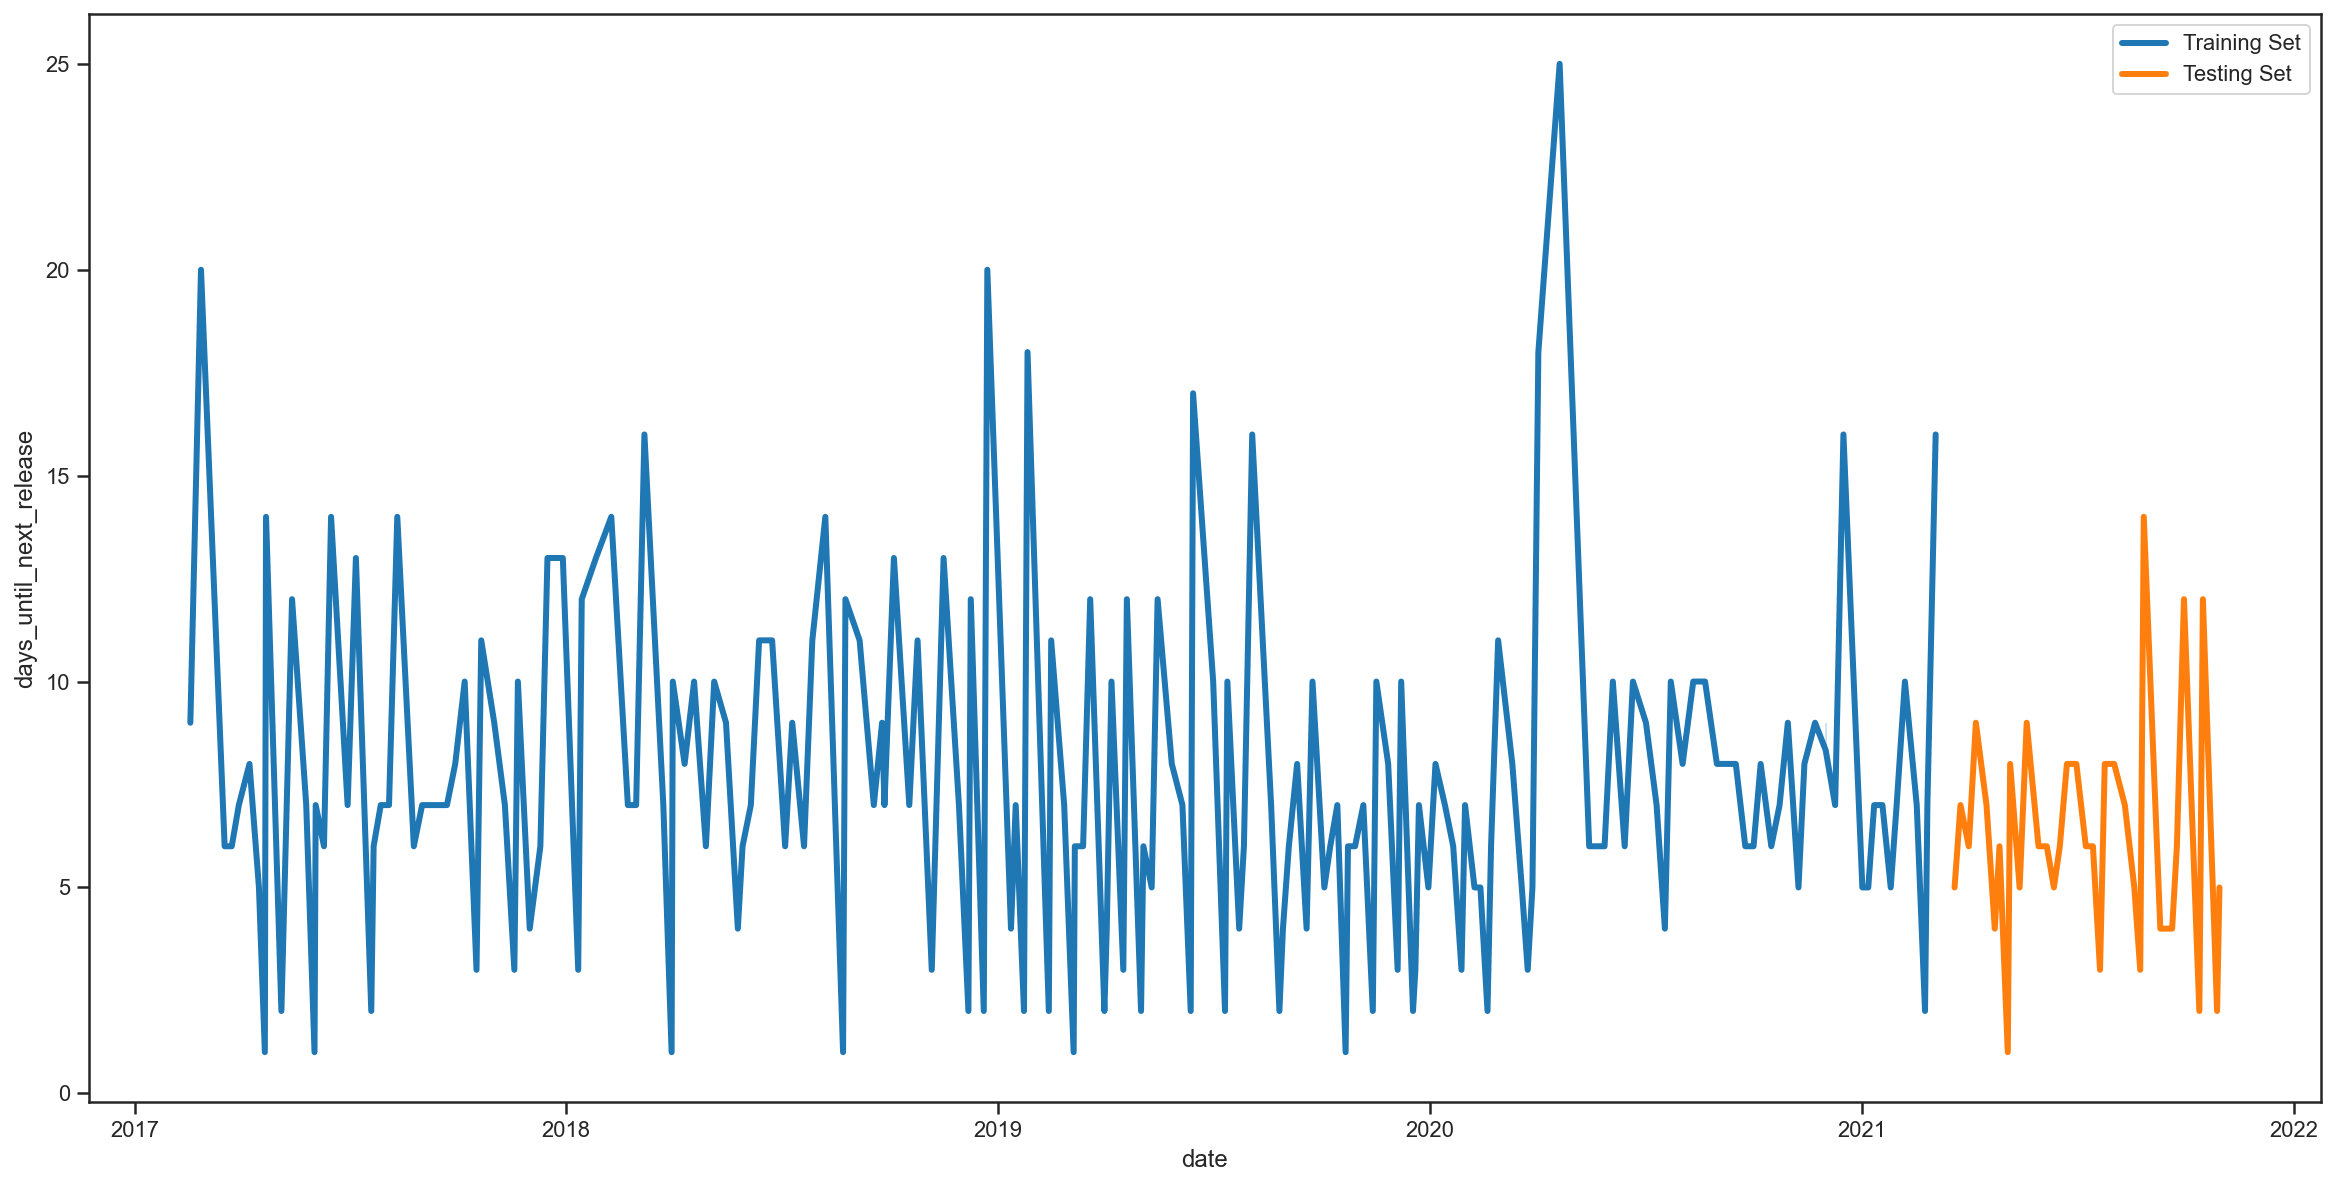

In [151]:
ax = sns.lineplot(data=train_df, x="date", y="days_until_next_release", color="tab:blue", linewidth=3)
sns.lineplot(data=test_df, x="date", y="days_until_next_release", color="tab:orange", linewidth=3, ax=ax)
ax.legend(["Training Set", "Testing Set"])
plt.show()

In [152]:
train_df = train_df.rename(columns={"date" : "ds", "days_until_next_release" : "y"})
test_df = test_df.rename(columns={"date" : "ds", "days_until_next_release" : "y"})

In [153]:
m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
m.add_regressor("weekday_0")
m.add_regressor("weekday_1")
m.add_regressor("weekday_2")
m.add_regressor("weekday_3")
m.add_regressor("weekday_4")
m.add_regressor("weekday_5")
m.add_regressor("weekday_6")
m.add_country_holidays(country_name="US")

In [154]:
m.fit(train_df[["ds", "y"] + [c for c in train_df.columns if c.startswith("weekday_")]])

Initial log joint probability = -9.17491


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       261.871   9.64919e-06       92.2201   8.755e-08       0.001      167  LS failed, Hessian reset 
      99       261.871   1.83904e-06       96.2659      0.4721      0.4721      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       261.872   1.00705e-08       93.0441      0.7235      0.7235      218   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [155]:
predictions = m.predict(test_df[["ds"] + [c for c in test_df.columns if c.startswith("weekday_")]])
predictions = predictions.merge(test_df[["ds", "y"]], on="ds", how="left")

In [156]:
predictions = predictions[["ds", "y", "yhat", "yhat_lower", "yhat_upper"]].copy()

In [157]:
predictions = predictions.set_index("ds")

In [158]:
predictions = predictions.round(0)

In [159]:
mape(predictions["y"], predictions["yhat"])

0.6550793650793652

In [160]:
mape(predictions["y"], predictions["yhat_lower"])

0.5775736961451248

In [161]:
mape(predictions["y"], predictions["yhat_upper"])

1.6024149659863944

In [162]:
predictions

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2021-03-20,5.0,8.0,3.0,13.0
2021-03-25,7.0,7.0,2.0,12.0
2021-04-01,6.0,7.0,2.0,12.0
2021-04-07,9.0,7.0,2.0,12.0
2021-04-16,7.0,7.0,2.0,12.0
2021-04-23,4.0,7.0,2.0,12.0
2021-04-27,6.0,6.0,1.0,11.0
2021-05-04,1.0,6.0,1.0,11.0
2021-05-06,8.0,7.0,2.0,12.0


In [163]:
last_release = pandas.DataFrame([{"ds" : last_release}])
last_release["weekday"] = last_release["ds"].apply(lambda x : x.weekday())
last_release = pandas.get_dummies(last_release, columns=["weekday"], prefix="weekday")
for w in range(0, 7):
    col_name = "weekday_{}".format(w)
    if col_name not in last_release.columns:
        last_release[col_name] = 0
last_release

,ds,weekday_3,weekday_0,weekday_1,weekday_2,weekday_4,weekday_5,weekday_6
0,2021-11-04,1,0,0,0,0,0,0


In [164]:
last_release = last_release[sorted(last_release.columns)]

In [165]:
m.predict(last_release)[["ds", "yhat", "yhat_lower", "yhat_upper"]].round(0)

,ds,yhat,yhat_lower,yhat_upper
0,2021-11-04,7.0,2.0,12.0
